In [1]:
import datajoint as dj
import os

os.chdir('../..')
dj.config.load('dj_local_conf.json')

import pathlib
import numpy as np
import pandas as pd
import datetime
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [2]:
mlims = dj.create_virtual_module('mlims', dj.config['custom'].get('mlims.database'))
from ephys import (reference, ephys, acquisition, behavior, tracking, analysis, analysis_param)

Connecting thinh@workshop-db.datajoint.io:3306


# Part 1: Example use-case for extracting spikes and tracking data

### The figure below shows the overall structure of an ephys session embedded in this pipeline

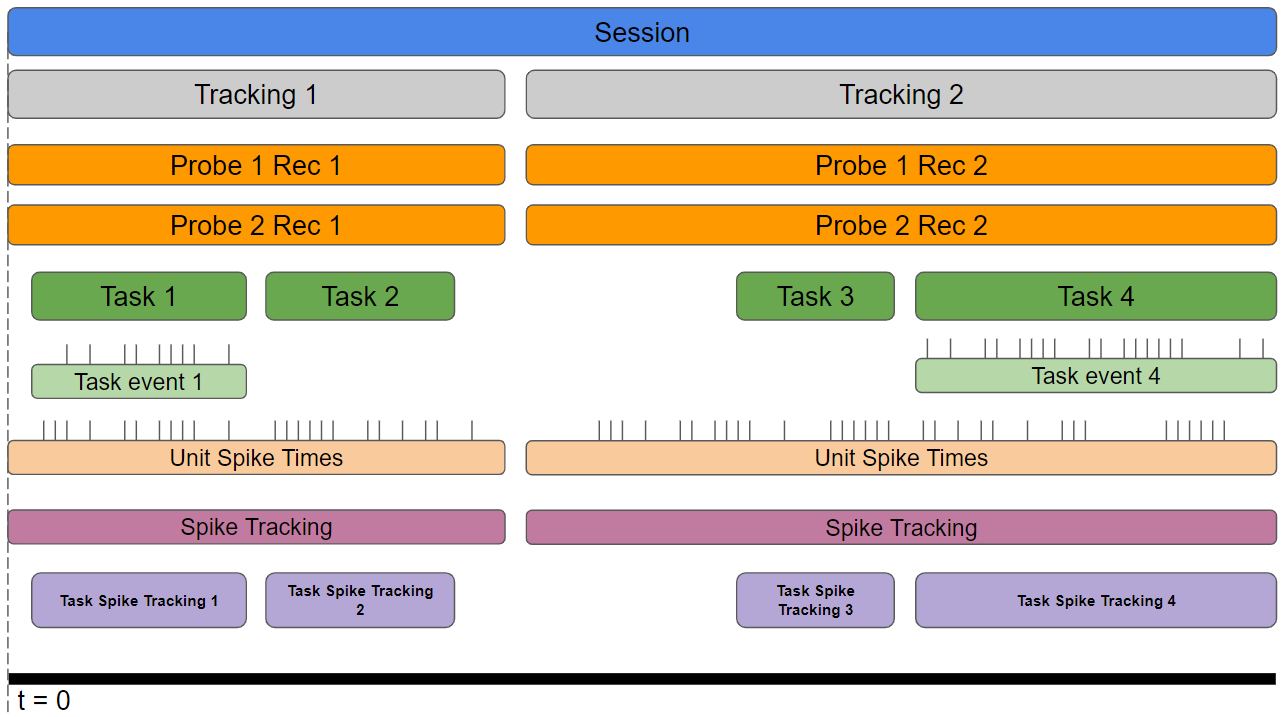

In [43]:
from IPython.display import Image
Image(filename='images/ephys_session_structure.png', width=720, height=480) 

### The ERD below presents parts of the pipeline relevant to spikes and tracking data.
We are interested in extracting data from the `TaskSpikesTracking` table:
>tracking data (e.g. position, speed, head angle, etc.) associated with each spike, per unit, in a particular behavior task.

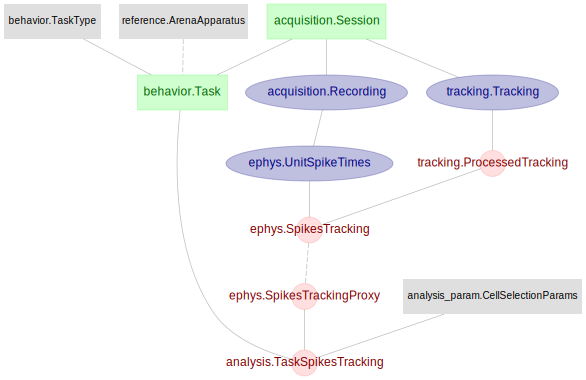

In [71]:
dj.ERD(analysis.TaskSpikesTracking) - 2 + dj.ERD(ephys.UnitSpikeTimes) + dj.ERD(tracking.ProcessedTracking)

Thus, to query `TaskSpikesTracking`, we need to decide on:
+ which ***session***
+ which ***task***
+ which ***unit***
+ which ***cell selection parameter***

Select ***session***

In [7]:
acquisition.Session * mlims.Animal & 'animal_name = 25624'

animal_id,datasource_id,session_time start time of this session,session_note,animal_species,animal_name,animal_sex,animal_dob,color
00592804fdd6aec0,0,2018-07-03 20:32:28,=BLOB=,rat,25624,M,2019-03-26,Unknown


The ***session*** and ***task*** selection is straight forward, let's show all tasks and pick one  as follow:

In [6]:
behavior.Task()

animal_id,datasource_id,session_time start time of this session,task_type,task_start (s) timestamps of task onset with respect to the start of the session,task_stop (s) timestamps of task onset with respect to the start of the session,arena_apparatus
00117ffddc698482,0,2019-03-27 10:36:57,OpenField,0.00,1525.0,square80
00117ffddc698482,0,2019-03-27 10:36:57,PhotoStim,1604.00,3405.0,square80
00592804fdd6aec0,0,2018-07-03 20:32:28,OpenField,0.00,339.0,square80


In [8]:
task_key = {'session_time': '2019-03-27 10:36:57', 'task_type': 'PhotoStim', 'task_start': 1604.00}

In [9]:
analysis.TaskSpikesTracking & task_key

animal_id,datasource_id,session_time start time of this session,task_type,task_start (s) timestamps of task onset with respect to the start of the session,unit unit id,spike_tracking_hash hash of the SpikesTracking primary_key,cell_selection_params_name user-friendly name,spike_times (s) task-related spike times (time with respect to the start of the task),speed (cm/s) task-related speed at each spike times,x_pos (cm) task-related x-pos at each spike times,y_pos (cm) task-related y-pos at each spike times,z_pos (cm) task-related z-pos at each spike times,head_yaw (degree) task-related head yaw (left/right angle) at each spike times,head_pitch (degree) task-related head pitch (up/down) at each spike times,head_roll (degree) task-related head roll (clockwise/anticlockwise) at each spike times,angular_speed (degree/s) task-related head angular speed at each spike times,insertion_time When this probe was inserted,group_name,time_window_id or maybe a hash of all the part windows,cluster_method name of clustering method,"cluster_param_name some unique name, or maybe hash of the dict of the param (ordered)","probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),sync_method sync method name,curation_timestamps ensure complete datetime here to prevent collision (in the rare case of multiple people curate at the exact same datetime),recording_time start time of this recording,tracking_time start time of this tracking recording,tracking_processing_method
00117ffddc698482,0,2019-03-27 10:36:57,PhotoStim,1604.00,6009,3fc62ad1afda5bd6fe3ed22379fc2373,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2019-06-05 07:08:00,det_11175674880ff1df1f8014f76b3e9e06,a1c6a0bfe97cd18966cb6fdb87c75687,klustakwik,default_klustakwik,4-tetrode-array,657119cc9e911c2c8a536abce16264f0,presync,2019-08-01 00:34:00,2019-03-27 11:03:41,2019-03-27 11:03:41,2d_2led


The selection of ***unit*** is more involved:

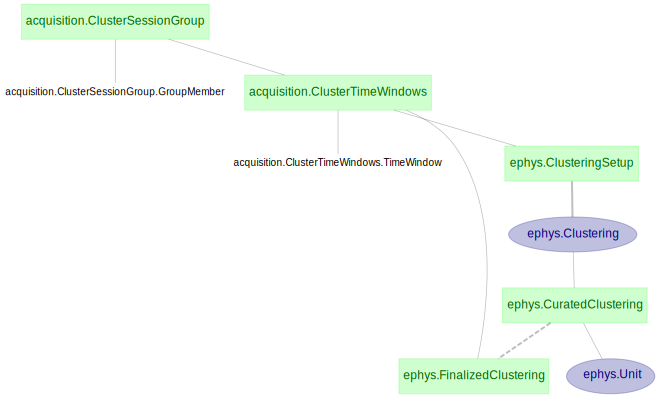

In [17]:
dj.ERD(ephys.Unit) + (dj.ERD(acquisition.ClusterSessionGroup) + 2) + dj.ERD(ephys.CuratedClustering)

Thus, to select the units, one has to decide on which ***ClusterSessionGroup*** and ***ClusterTimeWindows*** to obtain the clustering from. 

For most cases, we would like to look at the ***ClusterSessionGroup*** that contain only a single session of which we are interested in, and the ***ClusterTimeWindows*** containing a single time-window spanning the entire session (we often refer to this choice as the ***default*** choice). 

Once ***ClusterSessionGroup*** and ***ClusterTimeWindows*** are decided, the next decision is on which ***CuratedClustering*** to inspect, as the same clustering can undergo multiple curations. 

Essentially, the selection of the ***Unit*** table conforms to this choice-matrix:

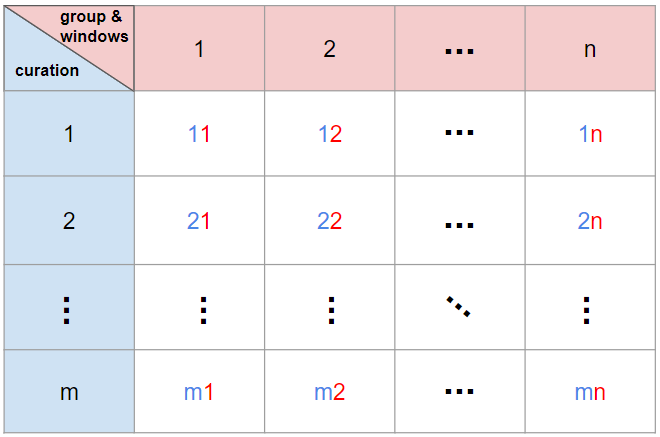

In [21]:
from IPython.display import Image
Image(filename='images/Clustering_ChoiceMatrix.png', width=400, height=300) 

#### As an example, let's pick the ***default*** group and time-window for this session.

We make use of a built-in function `get_default_cluster_time_window()` from `ephys.utilities.ingestion`. This function return ALL ***ClusterTimeWindows*** with single session and single time-window spanning the entire session.

In [22]:
from ephys.utilities.ingestion import get_default_cluster_time_window

In [23]:
default_group_window = get_default_cluster_time_window()

In [24]:
default_group_window

group_name,time_window_id or maybe a hash of all the part windows
det_11175674880ff1df1f8014f76b3e9e06,a1c6a0bfe97cd18966cb6fdb87c75687
det_a261ba6da0617e0e9dbcb9464d0d0b78,a1c6a0bfe97cd18966cb6fdb87c75687
det_b331a8a5f538f731f6c23dfa9bcd0f1c,a1c6a0bfe97cd18966cb6fdb87c75687


Now extract the one for the currently selected session (embedded in `task_key`)

In [28]:
sess_group_window = (default_group_window & (acquisition.ClusterSessionGroup.GroupMember & task_key)).fetch1('KEY')

In [29]:
sess_group_window

{'group_name': 'det_11175674880ff1df1f8014f76b3e9e06',
 'time_window_id': 'a1c6a0bfe97cd18966cb6fdb87c75687'}

#### And then pick a curation (e.g. 1st one in the list)

In [32]:
curation = (ephys.CuratedClustering & sess_group_window).fetch('KEY')[0]

In [33]:
curation

{'animal_id': '00117ffddc698482',
 'datasource_id': 0,
 'insertion_time': datetime.datetime(2019, 6, 5, 7, 8),
 'group_name': 'det_11175674880ff1df1f8014f76b3e9e06',
 'time_window_id': 'a1c6a0bfe97cd18966cb6fdb87c75687',
 'cluster_method': 'klustakwik',
 'cluster_param_name': 'default_klustakwik',
 'probe_model': '4-tetrode-array',
 'electrode_config_id': '657119cc9e911c2c8a536abce16264f0',
 'sync_method': 'presync',
 'curation_timestamps': datetime.datetime(2019, 8, 1, 0, 34)}

Full defining a `TaskSpikesTracking` requires:
+ `task_key`
+ `sess_group_window`
+ `curation`
+ ***cell_selection_params_name***
+ ***unit***

In [36]:
selector = {**task_key, **sess_group_window, **curation, 'cell_selection_params_name': 1}

In [39]:
analysis.TaskSpikesTracking & selector

animal_id,datasource_id,session_time start time of this session,task_type,task_start (s) timestamps of task onset with respect to the start of the session,unit unit id,spike_tracking_hash hash of the SpikesTracking primary_key,cell_selection_params_name user-friendly name,spike_times (s) task-related spike times (time with respect to the start of the task),speed (cm/s) task-related speed at each spike times,x_pos (cm) task-related x-pos at each spike times,y_pos (cm) task-related y-pos at each spike times,z_pos (cm) task-related z-pos at each spike times,head_yaw (degree) task-related head yaw (left/right angle) at each spike times,head_pitch (degree) task-related head pitch (up/down) at each spike times,head_roll (degree) task-related head roll (clockwise/anticlockwise) at each spike times,angular_speed (degree/s) task-related head angular speed at each spike times
00117ffddc698482,0,2019-03-27 10:36:57,PhotoStim,1604.00,6009,3fc62ad1afda5bd6fe3ed22379fc2373,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


#### From the selected `TaskSpikesTracking`, fetch back: spike_times, speed, x-pos, y-pos, head-angle

In [40]:
spike_times, speed, x_pos, y_pos, head_angle = (analysis.TaskSpikesTracking & selector & 'unit=6009').fetch1(
    'spike_times', 'speed', 'x_pos', 'y_pos', 'head_yaw')

#### Turn into a Pandas DataFrame

In [63]:
pos = pd.DataFrame((spike_times, speed, x_pos, y_pos, head_angle)).T

In [64]:
pos.columns = ['spike_times', 'speed', 'x_pos', 'y_pos', 'head_yaw']

In [67]:
pos.head(10)

,spike_times,speed,x_pos,y_pos,head_yaw
0,5.724812,22.576238,53.542168,13.903958,5.607338
1,6.205583,17.693331,46.938960,14.163294,5.390577
2,13.443417,15.356844,29.404690,51.731311,0.556780
3,15.621896,8.519667,30.316550,62.150253,2.907222
4,16.702313,15.543739,36.898251,64.922951,2.463020
5,17.562542,7.327620,38.902935,68.859349,2.086904
6,19.015292,26.551428,42.555824,67.700775,3.301975
7,19.258937,16.725025,43.332162,63.061400,3.510185
8,19.343146,13.738459,44.638761,62.364991,3.429291
9,19.614333,18.239472,48.256643,62.786570,2.852313


# Part 2: The Cell Analysis Results

### The same logic can be applied to all the analysis tables in the ***analysis*** schema:
+ AngularOccupancy (***unit*** specification not required)
+ SpatialOccupancy (***unit*** specification not required)
+ HDTuning
+ RateMap
+ GridScore
+ BorderScore
+ SpeedScore

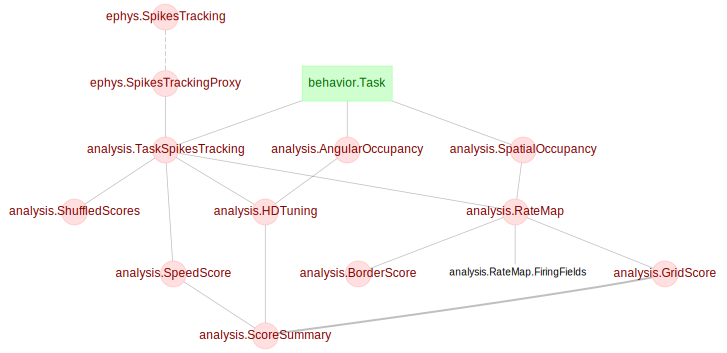

In [46]:
dj.ERD(analysis) - dj.ERD(analysis.SkippedTaskSpikesTracking) + dj.ERD(behavior.Task) + dj.ERD(ephys.SpikesTracking)

For example, retrieve ***RateMap*** and ***GridScore*** from the selected unit above

In [47]:
selector = {**task_key, **sess_group_window, **curation,
            'smoothing_params_name': 1,
            'occu_params_name': 1,
            'field_detect_params_name': 1,
            'analysis_package': 'python'}

In [50]:
ratemap, grid_score = (analysis.GridScore * analysis.RateMap & selector & 'unit=6009').fetch1('ratemap', 'grid_score')

In [51]:
grid_score

-0.153791

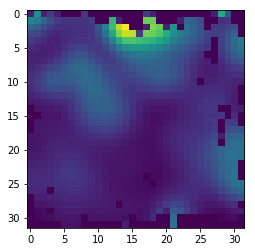

In [56]:
plt.imshow(ratemap)

___________________________________________________________________________________________________________________

Clearly, ones can follow the steps above and be able to explore and retrieve any data and results from the entire pipeline - one catch, you just need to get the query correctly.

However, that is quite a big catch, as selecting the right ***ClusterSessionGroup*** and ***ClusterTimeWindows*** can be a bit convoluted, especially when there are thousands of recording sessions. On top of that are the multiple ***CuratedClustering***.

After navigating through all that, users still have to decide on the a number of ***analysis parameters*** to get to the final results. 

That's a lot of work to go through just to get to the beautiful results. However, a fairly small price to pay for such versatile, and sophisticated pipeline. Acknowledging the cumbersomeness of navigating this pipeline, there are several "shortcuts" built-in to help users get to the core results quicker. These will be introduced and described in detail [here](Part_2_cell_analysis_results.ipynb)

# ===========================================